In [1]:
import pyart 
import xarray as xr
import xradar as xd
import fsspec


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
bucket = 's3://s3-radaresideam/'
bucket2 = 's3://s3-radaresideam/l2_data/2022/10/06/Guaviare/'
filename = f"{bucket}l2_data/2022/10/06/Guaviare/GUA221006000012.RAWHDKV"

In [3]:
of = pyart.io.prepare_for_read(filename, storage_options={'anon': True})
radar = pyart.io.read(of)

/data/keeling/a/alfonso8/miniconda3/envs/radar/lib/python3.9/site-packages/pyart/io/sigmet.py:131: RuntimeWarning: invalid value encountered in sqrt
  sigmet_data, sigmet_metadata = sigmetfile.read_data(full_xhdr=full_xhdr)


In [4]:
radar.fields['reflectivity']

{'units': 'dBZ',
 'standard_name': 'equivalent_reflectivity_factor',
 'long_name': 'Reflectivity',
 'coordinates': 'elevation azimuth range',
 'data': masked_array(
   data=[[--, 3.5, 5.0, ..., --, --, --],
         [5.0, 6.5, 7.5, ..., --, --, --],
         [--, --, --, ..., --, --, --],
         ...,
         [--, 1.5, --, ..., --, --, --],
         [1.5, -3.0, 3.5, ..., --, --, 7.5],
         [0.5, 0.0, 3.0, ..., --, --, --]],
   mask=[[ True, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True, False,  True, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True, False],
         [False, False, False, ...,  True,  True,  True]],
   fill_value=1e+20,
   dtype=float32),
 '_FillValue': -9999.0}

In [5]:
file = fsspec.open_local(f'simplecache::{filename}', s3={'anon': True}, filecache={'cache_storage':'.'})
ds = xr.open_dataset(file, engine="iris", group=1 )

In [6]:
ds

<xarray.Dataset>
Dimensions:       (time: 720, range: 994)
Coordinates:
    azimuth       (time) float64 ...
  * range         (range) float32 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    elevation     (time) float32 ...
  * time          (time) datetime64[ns] 2022-10-06T00:00:13.330000 ... 2022-1...
    longitude     float64 ...
    latitude      float64 ...
    altitude      float64 ...
Data variables: (12/17)
    DBTH          (time, range) float32 ...
    DBZH          (time, range) float32 ...
    VRADH         (time, range) float32 ...
    WRADH         (time, range) float32 ...
    ZDR           (time, range) float32 ...
    KDP           (time, range) float32 ...
    ...            ...
    DB_DBZE8      (time, range) int16 ...
    sweep_mode    <U20 ...
    sweep_number  int64 ...
    prt_mode      <U7 ...
    follow_mode   <U7 ...
    fixed_angle   float64 ...

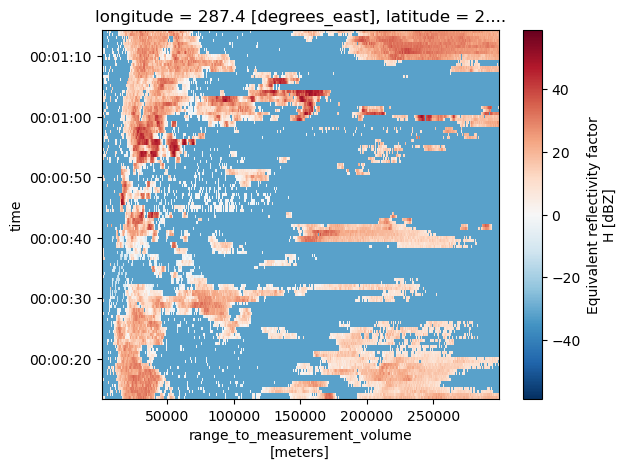

In [7]:
ds.DBZH.plot()

In [8]:
ds = xd.georeference.get_x_y_z(ds)

In [9]:
ds

<xarray.Dataset>
Dimensions:       (time: 720, range: 994)
Coordinates:
    azimuth       (time) float64 75.75 76.25 76.75 77.25 ... 74.25 74.75 75.25
  * range         (range) float32 1e+03 1.3e+03 1.6e+03 ... 2.986e+05 2.989e+05
    elevation     (time) float64 0.5054 0.5054 0.5054 ... 0.4834 0.4834 0.4834
  * time          (time) datetime64[ns] 2022-10-06T00:00:13.330000 ... 2022-1...
    longitude     float64 287.4
    latitude      float64 2.534
    altitude      float64 240.0
    x             (range, time) float64 969.2 971.3 ... 2.882e+05 2.888e+05
    y             (range, time) float64 246.1 237.7 ... 7.856e+04 7.604e+04
    z             (range, time) float64 8.696 8.696 ... 7.777e+03 7.777e+03
Data variables: (12/17)
    DBTH          (time, range) float32 ...
    DBZH          (time, range) float32 ...
    VRADH         (time, range) float32 ...
    WRADH         (time, range) float32 ...
    ZDR           (time, range) float32 ...
    KDP           (time, range) float32 ...
    ...            ...
    DB_DBZE8      (time, range) int16 ...
    sweep_mode    <U20 'azimuth_surveillance'
    sweep_number  int64 1
    prt_mode      <U7 'not_set'
    follow_mode   <U7 'not_set'
    fixed_angle   float64 0.5

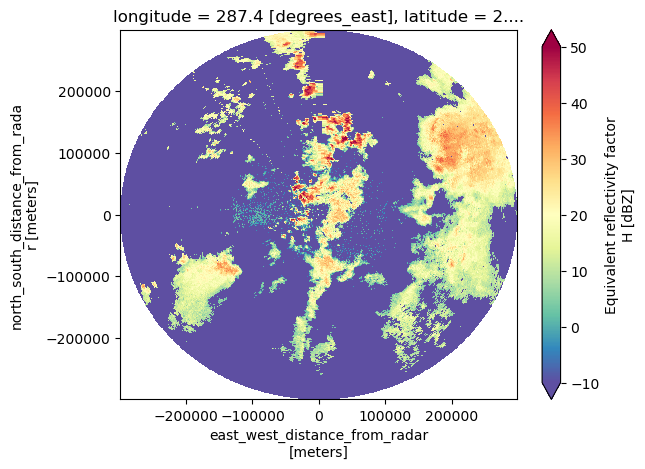

In [17]:
ds.DBZH.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50)

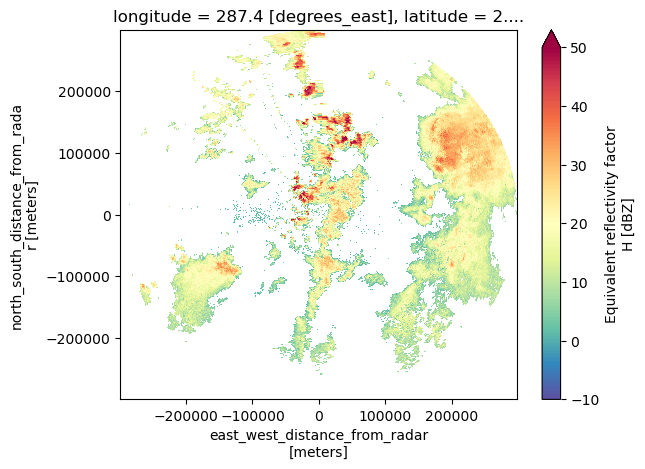

In [16]:
ds.DBZH.where(ds.DBZH > 0).plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50)

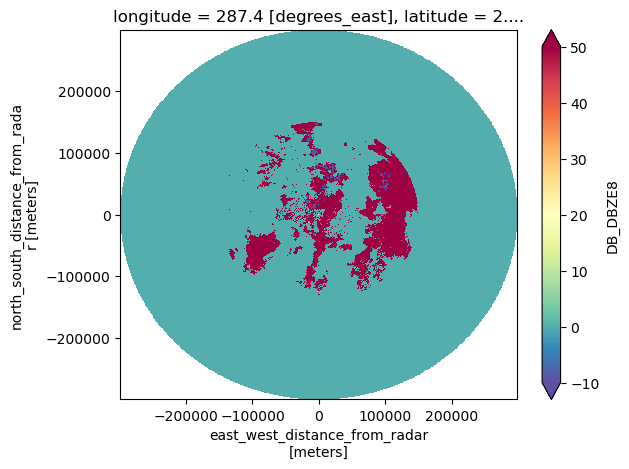

In [20]:
ds.DB_DBZE8.plot(x='x', y='y', cmap='Spectral_r', vmin=-10, vmax=50)

In [11]:
fs = fsspec.filesystem('s3', anon=True)
urls = [f'//s3://{i}' for i in fs.glob(bucket2)]

In [12]:
! /tmp/files

/bin/bash: /tmp/files: No such file or directory
